In [36]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import errno
import cvlib
import io

# import matplotlib.pyplot as plt

%matplotlib inline
#plt.style.use('dark_background') 
PATH = 'C:/GitHub/pythonPrograms/computerVision2023/clases/imagenes/'

In [56]:
type(np.zeros(4))

numpy.ndarray

In [58]:
# array = np.array([0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 255, 255, 255, 0, 0, 0, 0, 0, 255, 255, 255, 0, 0, 0, 0, 0, 255, 255, 255, 0, 0, 0, 0, 0, 255, 255, 255, 0, 0, 0, 255, 0, 0, 255, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 255, 0, 255, 0, 0, 0, 0, 255, 255])
# img = np.ndarray((8,8),buffer=array,dtype=int)

In [71]:
im = cv.imread(PATH+'cells.png', cv.IMREAD_COLOR)
img = cv.cvtColor(im, cv.COLOR_RGB2GRAY)

#### imgpad

In [48]:
def imgpad(img, r):
    if type(r) != int:
        raise TypeError("'r' must be an integer")
        return

    if type(img) != np.ndarray:
        raise TypeError("'img' must be an numpy.ndarray")
        return

    shapeY, shapeX = img.shape
    newShapeY = shapeY + (2*r)
    newShapeX = shapeX + (2*r)

    newImage = np.ndarray((newShapeY,newShapeX), buffer=np.zeros(newShapeX*newShapeY),offset=np.int_().itemsize,dtype=int)

    for i in range(shapeY):
        modifiedRow = np.append(np.zeros(r), img[i])
        modifiedRow = np.append(modifiedRow, np.zeros(r))
        np.copyto(newImage[i+r,:],modifiedRow,casting='unsafe')
        
    return newImage


In [72]:
img.shape

(355, 473)

In [73]:
newImage = imgpad(img,10)
newImage.shape

(375, 493)

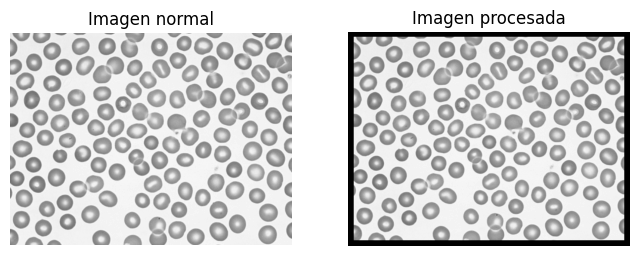

In [74]:
cvlib.imgcmp(img, newImage, ['Imagen normal', 'Imagen procesada'])

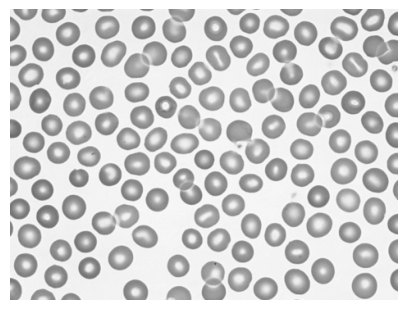

In [75]:
cvlib.imgview(img, k=5)

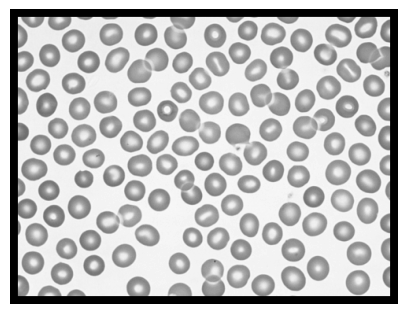

In [76]:
cvlib.imgview(newImage, k=5)

In [80]:
type(img)

numpy.ndarray

In [81]:
thresh_val = 180
binarized = cv.threshold(img,thresh_val,255, cv.THRESH_BINARY_INV)[1]

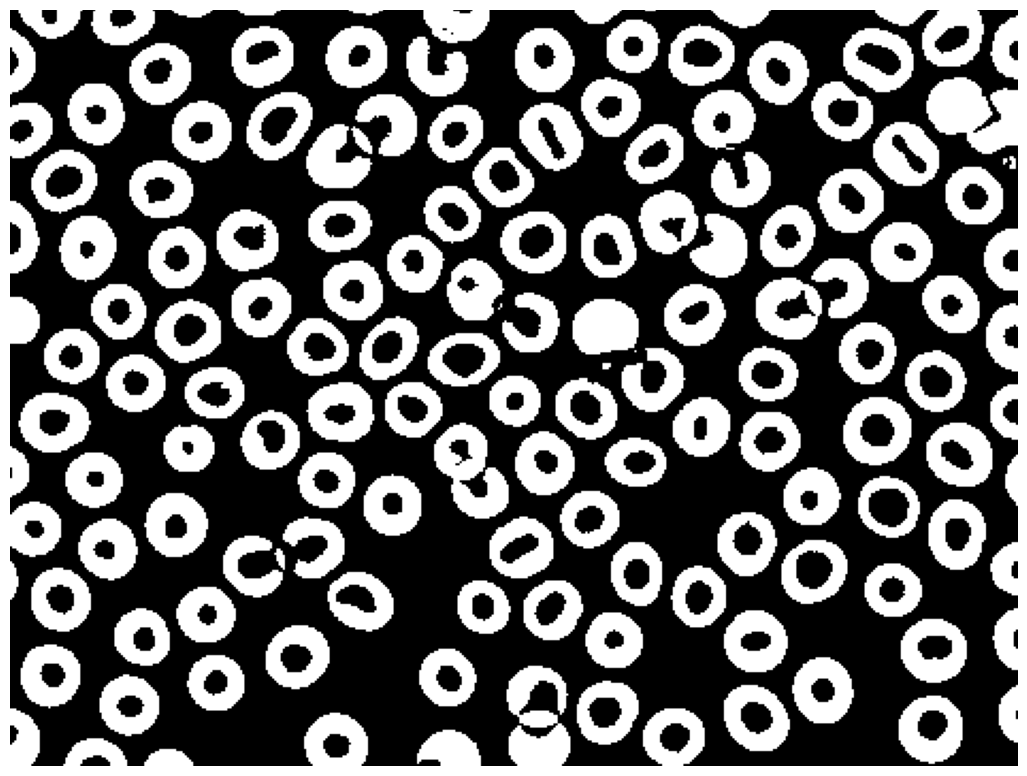

In [82]:
cvlib.imgview(binarized)

In [ ]:
def connected_c(img):
    pass